In [ ]:
import numpy as np
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

from src.models import CNN
from src.hmc import initialize_weights, HMC_sampling, flatten_chain
from src.eval import plot_grid, compute_r_hat, plot_r_hat_histogram, prepare_chains, compute_r_hat_per_image

Dataloader

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Chargement des données MNIST
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])  # MNIST est en niveaux de gris

batch_size = 32
# Dataloaders
trainset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
testset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
test_loader = DataLoader(testset, batch_size=batch_size, shuffle=False, drop_last=True) # drop_last to stack the outputs and target later

Sampling 3 chains

In [4]:
# Hyperparamètres
prior_std = 1
step_size = 0.0005
n_leapfrog = 20  
n_burnin = 30
n_samples = 200
n_classes = 10
post_temp = 1.

# Chaîne 1
np.random.seed(123)
model = CNN(output_dim=10).to(device)
initialize_weights(model, mean=0.0, std=prior_std)
theta = [p.clone().detach().to(device) for p in model.parameters()]  # Déplacer les paramètres du modèle sur le GPU
params_hmc_1 = HMC_sampling(model, theta, train_loader, step_size, n_leapfrog, n_burnin, n_samples, temperature=post_temp, device=device)

# Chaîne 2
np.random.seed(231)
model = CNN(output_dim=10).to(device)
initialize_weights(model, mean=0.0, std=prior_std)
theta = [p.clone().detach().to(device) for p in model.parameters()]  # Déplacer les paramètres du modèle sur le GPU
params_hmc_2 = HMC_sampling(model, theta, train_loader, step_size, n_leapfrog, n_burnin, n_samples, temperature=post_temp, device=device)

# Chaîne 2
np.random.seed(321)
model = CNN(output_dim=10).to(device)
initialize_weights(model, mean=0.0, std=prior_std)
theta = [p.clone().detach().to(device) for p in model.parameters()]  # Déplacer les paramètres du modèle sur le GPU
params_hmc_3 = HMC_sampling(model, theta, train_loader, step_size, n_leapfrog, n_burnin, n_samples, temperature=post_temp, device=device)

Burn in phase:   0%|          | 0/30 [00:00<?, ?it/s]

Sampling phase: 100%|██████████| 200/200 [04:01<00:00,  1.21s/it]


Sampling finished. 200 samples with 0.51 acceptance_ratio.


Sampling phase: 100%|██████████| 200/200 [04:03<00:00,  1.22s/it]


Sampling finished. 200 samples with 0.51 acceptance_ratio.


Sampling phase: 100%|██████████| 200/200 [04:05<00:00,  1.23s/it]

Sampling finished. 200 samples with 0.44 acceptance_ratio.


## Visualizing cross-section

Evaluating samples: 100%|██████████| 16/16 [03:15<00:00, 12.24s/it]


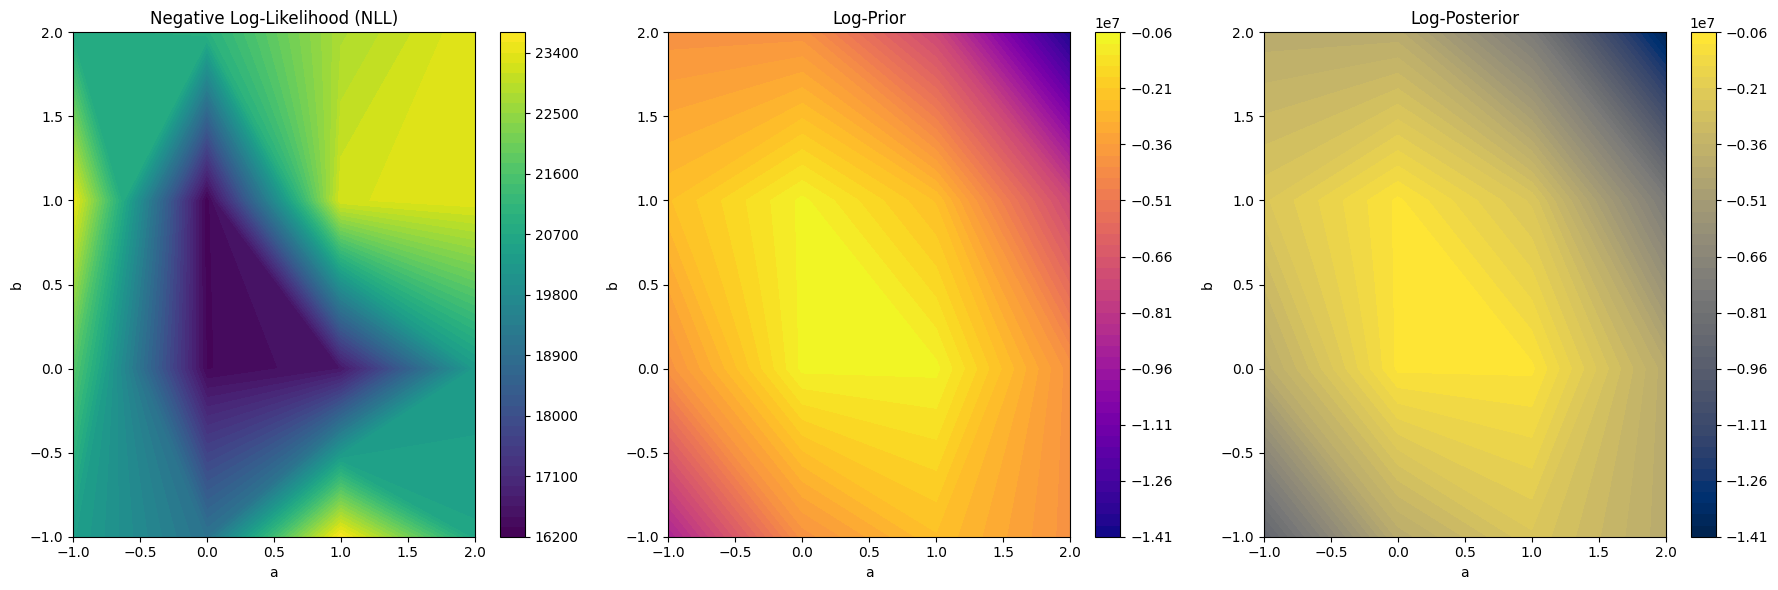

In [5]:
# Sélectionner 3 échantillons (1er, 50e, 100e)
w1 = params_hmc_1[60]
w2 = params_hmc_2[120]
w3 = params_hmc_3[180] # 40, 100, 140

plot_grid(test_loader, model, w1, w2, w3, grid_size=4, n_classes=10, max_nll=1000000, device=device, verbose=False)

## Computing R ratios

c:\Users\soelm\Documents\04_Code\Bayesian_posteriors\eval.py:344: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


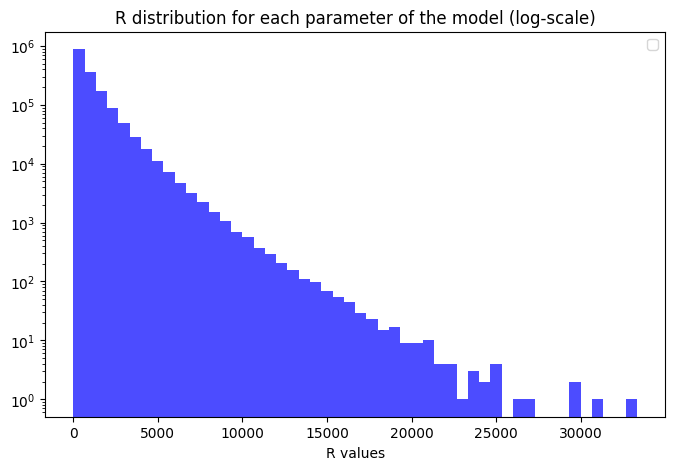

In [6]:
# Convertir chaque chaîne en un tenseur
chain_1_tensor = flatten_chain(params_hmc_1)  # (num_samples N, num_params D)
chain_2_tensor = flatten_chain(params_hmc_2)
chain_3_tensor = flatten_chain(params_hmc_3)

# Empiler les chaînes pour obtenir une forme (M, N, D)
chains = torch.stack([chain_1_tensor, chain_2_tensor, chain_3_tensor])  # (3, num_samples, num_params)

# Calcul des valeurs de R-hat
r_hat_values = compute_r_hat(chains)

# Afficher l'histogramme des valeurs de R-hat
plot_r_hat_histogram(r_hat_values, "R distribution for each parameter of the model (log-scale)")

In [ ]:
# Very slow for function spaces
chains = [params_hmc_1, params_hmc_2] #, params_hmc_3]

predicted_tensors = prepare_chains(model, test_loader, chains, device='cpu')
r_hat_values_function = compute_r_hat_per_image(predicted_tensors)

Evaluating chain:   4%|▍         | 9/200 [01:50<39:07, 12.29s/it]


KeyboardInterrupt: 